In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777) #reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# hyper parameters
learning_rate=0.001
training_epochs = 15
batch_size=100

# sess = tf.Session() 이거 나중에 해줘도 실행되는듯
class Model:
  def __init__(self, sess, name):
    self.sess = sess
    self.name = name
    self._build_net()
  
  def _build_net(self):
    with tf.variable_scope(self.name):
      # dropout (keep_prob) rate 0.7~0.5 on training, but shoud be 1 for testing
      self.keep_prob = tf.placeholder(tf.float32)
      
      # input placeholders
      self.X = tf.placeholder(tf.float32, [None, 784]) #MNIST_data
      # img 28x28x1 (black/white)
      X_img = tf.reshape(self.X, [-1, 28, 28, 1])
      self.Y = tf.placeholder(tf.float32, [None, 10])
      
      # L1 ImgIn shape =(?, 28, 28, 1)
      W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
      # Conv -> (?, 28, 28, 32), Pool -> (?, 14, 14, 32)
      L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding="SAME")
      L1 = tf.nn.relu(L1) #Activation
      # ksize = kernel
      L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
      
      # L2 ImgInput shape = (?, 14, 14, 32)
      # input layer에 32개의 층이 있으므로 W2size=3x3x32
      W2 = tf.Variable(tf.random_normal([3,3,32,64], stddev=0.01)) 
      # Conv -> ?x14x14x64, Pool -> ?,7x7x64
      L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
      L2 = tf.nn.relu(L2)
      L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
      
      W3 = tf.Variable(tf.random_normal([3,3,64,128], stddev=0.01))
      # Conv -> ?x7x7x128, Pool -> ?,4x4x128
      # Reshape -> ?x4*4*128 (Flatten for FC input)
      L3 = tf.nn.conv2d(L2, W3, strides=[1,1,1,1], padding="SAME")
      L3 = tf.nn.relu(L3)
      L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)
      
      L3_flat = tf.reshape(L3, [-1, 4*4*128])
      
      
      # L4 FC 4x4x128 inputs -> 625 outputs
      W4 = tf.get_variable("W4", shape=[4*4*128, 625],
                          initializer=tf.contrib.layers.xavier_initializer())
      b4 = tf.Variable(tf.random_normal([625]))
      L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
      L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
      
      # L5 Final FC, 625 inputs -> 10 outputs
      W5 = tf.get_variable("W5", shape=[625,10],
                          initializer=tf.contrib.layers.xavier_initializer())
      b5 = tf.Variable(tf.random_normal([10]))
      self.logits = tf.matmul(L4, W5) + b5
      
    #define cost & optimizer
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      logits = self.logits, labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(self.cost)
    
    correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
  def predict(self, x_test, keep_prob=1.0):
    return self.sess.run(self.logits, feed_dict={self.X: x_test, 
                                                 self.keep_prob:keep_prob})
  def get_accuracy(self, x_test, y_test, keep_prob=1.0):
    return self.sess.run(self.accuracy, feed_dict={self.X:x_test, self.Y:y_test,
                                                  self.keep_prob:keep_prob})
  def train(self, x_data, y_data, keep_prob=0.7):
    return self.sess.run([self.cost, self.optimizer], feed_dict={self.X:x_data,
                                                               self.Y:y_data,
                                                  self.keep_prob:keep_prob})
  
#Initialize
sess = tf.Session()
m1 = Model(sess, "m1") # Model(sess, name)

sess.run(tf.global_variables_initializer())
print("Learning Started!")

#Train Model 1 (m1)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = int(mnist.train.num_examples / batch_size)
  
  for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    c, _ = m1.train(batch_xs, batch_ys)
    avg_cost += c / total_batch
  
  print("Epoch:", "%04d" % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

print("Learning Finished")

print("Accuracy:", m1.get_accuracy(mnist.test.images, mnist.test.labels))
      
      

      

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning Started!
Epoch: 0001 cost = 0.374757254
Epoch: 0002 cost = 0.103190398
Epoch: 0003 cost = 0.074413103
Epoch: 0004 cost = 0.060829044
Epoch: 0005 cost = 0.051534798
Epoch: 0006 cost = 0.047413803
Epoch: 0007 cost = 0.042485250
Epoch: 0008 cost = 0.039865326
Epoch: 0009 cost = 0.035028612
Epoch: 0010 cost = 0.033553078
Epoch: 0011 cost = 0.031340341
Epoch: 0012 cost = 0.029049419
Epoch: 0013 cost = 0.030466464
Epoch: 0014 cost = 0.026057850
Epoch: 0015 cost = 0.026122276
Learning Finished
Accuracy: 0.993


In [42]:
# tf.layers module 이용
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph() ## initialization of xavier weight

from tensorflow.examples.tutorials.mnist import input_data
tf.set_random_seed(777) # reproducibility
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

class Model:
  def __init__(self, sess, name):
    self.sess = sess
    self.name = name
    self._build_net()
    
  def _build_net(self):
    with tf.variable_scope(self.name):
      # dropout (keep_prob) rate 0.7~0.5 on trainig, but should be 1 for testing
      self.training = tf.placeholder(tf.bool) # True or False
      
      # input placeholders
      self.X = tf.placeholder(tf.float32, [None, 784])
      
      # img 28x28x1 (black/white), Input Layer
      X_img = tf.reshape(self.X, [-1, 28, 28, 1])
      self.Y = tf.placeholder(tf.float32, [None, 10])
      
      # Convolutional Layer 1 ##conv2d 메소드에서는 strides=[1,1]이 default 인듯
      conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      
      # Pooling Layer 1 out:14x14x1
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], 
                                     padding="SAME", strides=2)
      dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3,
                                  training=self.training) # rate = 1-keep_prob
      
      # Convolution Layer 2 and Pooling Layer 2  out:7x7x1
      conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],
                                     padding="SAME", strides=2)
      dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)
      
      #Conv, Pool 3 out:4x4x1
      conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2,2],
                                   padding="same", strides=2)
      dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3,
                                  training=self.training)
      
      # Dense layer with relu (FC 안의 layer) 
      # 4*4*128 -> 625 outputs
      flat = tf.reshape(dropout3, [-1, 4*4*128])
      dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
      dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, 
                                   training=self.training)
      
      # Logits (no activation) Layer : L5 Final FC 625 -> 10 ouputs
      self.logits = tf.layers.dense(inputs=dropout4, units=10)
      
    #define cost & optimizer
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      logits=self.logits, labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(self.cost)
    
    correct_prediction = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.Y,1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  def predict(self, x_test, training=False):
    return self.sess.run(self.logits,
                        feed_dict = {self.X: x_test, self.training: training})
  
  def get_accuracy(self, x_test, y_test, training=False):
    return self.sess.run(self.accuracy, 
                        feed_dict={self.X:x_test, self.Y:y_test, 
                                   self.training:training})
  
  def train(self, x_data, y_data, training=True):
    return self.sess.run([self.cost, self.optimizer], feed_dict={
        self.X:x_data, self.Y:y_data, self.training:training
    })
  
sess = tf.Session()
m1 = Model(sess, "m1")

print("Learning Started!")

sess.run(tf.global_variables_initializer())

for epoch in range(training_epochs):
  avg_cost=0
  total_batch = int(mnist.train.num_examples / batch_size)
  
  for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    c, _ = m1.train(batch_xs, batch_ys)
    avg_cost += c / total_batch
    
  print("Epoch:", "{}".format(epoch+1), "cost =", "{:.9f}".format(avg_cost))
  
print("Learning Finished!")

# Test model and check accuracy
print("Accuracy:", m1.get_accuracy(mnist.test.images, mnist.test.labels))
      
      
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning Started!
Epoch: 1 cost = 0.292427041
Epoch: 2 cost = 0.091751326
Epoch: 3 cost = 0.066484447
Epoch: 4 cost = 0.055796547
Epoch: 5 cost = 0.050598727
Epoch: 6 cost = 0.045347414
Epoch: 7 cost = 0.039887077
Epoch: 8 cost = 0.039795005
Epoch: 9 cost = 0.036911163
Epoch: 10 cost = 0.030787748
Epoch: 11 cost = 0.031576264
Epoch: 12 cost = 0.031317008
Epoch: 13 cost = 0.028855012
Epoch: 14 cost = 0.028800467
Epoch: 15 cost = 0.026394106
Learning Finished!
Accuracy: 0.9931


In [70]:
a = [[1,2],[3,4]]
print(a[1:2])

[[3, 4]]


Label: [9]
Miss Prediction: [4]


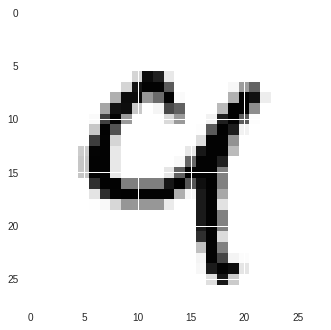

Label: [0]
Miss Prediction: [6]


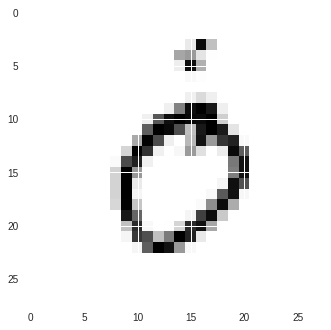

Label: [3]
Miss Prediction: [5]


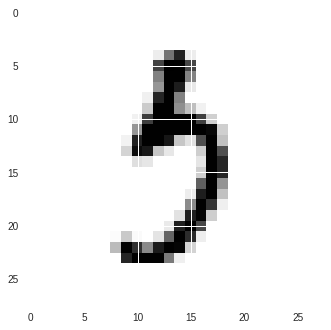

Label: [6]
Miss Prediction: [1]


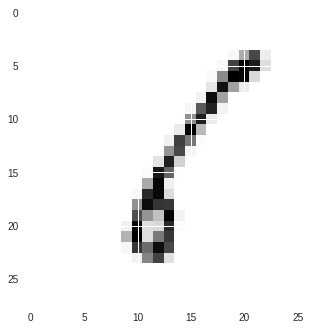

In [38]:
sess = tf.Session()
import random
for i in range(500):
  r = random.randint(0, mnist.test.num_examples - 1)
  label = sess.run(tf.argmax(mnist.test.labels[r:r+1], 1))
  predict = sess.run(tf.argmax(m1.predict(mnist.test.images[r:r+1]),1))
  if (predict != label):
    print("Label:", label)
    print("Miss Prediction:", predict)
    plt.imshow(mnist.test.images[r:r+1].reshape(28,28), cmap="Greys",
              interpolation="nearest")
    plt.show()
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 1 cost: 0.374172543
Epoch: 2 cost: 0.102106439
Epoch: 3 cost: 0.073865935
Epoch: 4 cost: 0.060665478
Epoch: 5 cost: 0.051290076
Epoch: 6 cost: 0.046435327
Epoch: 7 cost: 0.043441372
Epoch: 8 cost: 0.039303207
Epoch: 9 cost: 0.034867370
Epoch: 10 cost: 0.031813191
Epoch: 11 cost: 0.031032734
Epoch: 12 cost: 0.030354082
Epoch: 13 cost: 0.029956687
Epoch: 14 cost: 0.026576764
Epoch: 15 cost: 0.025980127
Learning Finished!
Accuracy: 0.9922
Get one img and predict!
Label: [0]
Prediction: [0]


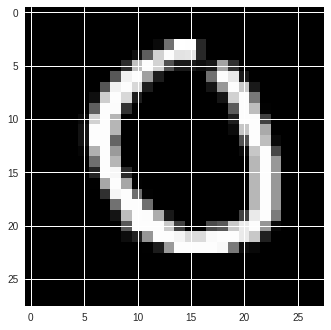

In [61]:
# 혼자 해보는 CNN with class
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
tf.reset_default_graph()

tf.set_random_seed(777)

# hyper parameters
learning_rate=0.001
training_epochs=15
batch_size=100

class Model:
  def __init__(self, sess, name):
    self.sess = sess
    self.name = name
    self._build_net()
    
  def _build_net(self):
    with tf.variable_scope(self.name):
      self.keep_prob = tf.placeholder(tf.float32)
      
      #inputs
      self.X = tf.placeholder(tf.float32, [None, 784])
      X_img = tf.reshape(self.X,[-1,28,28,1])
      self.Y = tf.placeholder(tf.float32, [None, 10])
      
      #Conv1, Pool1 (32 layers)
      W1 = tf.Variable(tf.random_normal([3,3,1,32], stddev=0.01))
      L1 = tf.nn.conv2d(X_img, W1, strides=[1,1,1,1], padding="SAME")
      L1 = tf.nn.relu(L1)
      L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L1 = tf.nn.dropout(L1, keep_prob = self.keep_prob)
      
      #Conv2, Pool2 (64 layers)
      W2 = tf.Variable(tf.random_normal([3,3,32,64], stddev=0.01))
      L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding="SAME")
      L2 = tf.nn.relu(L2)
      L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L2 = tf.nn.dropout(L2, keep_prob = self.keep_prob)
      
      #Conv3, Pool3 (128 layers -> 4x4x128)
      W3 = tf.Variable(tf.random_normal([3,3,64,128], stddev=0.01))
      L3 = tf.nn.conv2d(L2, W3, strides=[1,1,1,1], padding="SAME")
      L3 = tf.nn.relu(L3)
      L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)
      
      #FC (Flatten the inputs) -> 625 ouputs
      flat = tf.reshape(L3, [-1,4*4*128])
      W4 = tf.get_variable("W4", shape=[4*4*128, 625],
                          initializer=tf.contrib.layers.xavier_initializer())
      b4 = tf.Variable(tf.random_normal([625]))
      L4 = tf.nn.relu(tf.matmul(flat,W4)+b4)
      L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
      
      #Final FC -> 10 ouputs
      W5 = tf.get_variable("W5", shape=[625,10],
                          initializer = tf.contrib.layers.xavier_initializer())
      b5 = tf.Variable(tf.random_normal([10]))
      self.logits = tf.matmul(L4, W5)+ b5 #마지막 결과는 self.logits로 보관
      
    
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=self.logits, labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate).minimize(self.cost)
  
    correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
  def predict(self, x_test, keep_prob=1.0):
    return self.sess.run(tf.argmax(self.logits,1), feed_dict = {
        self.X:x_test, self.keep_prob:keep_prob
    })
    
  def get_accuracy(self, x_test, y_test, keep_prob=1.0):
    return self.sess.run(self.accuracy, feed_dict = {
        self.X:x_test, self.Y:y_test, self.keep_prob:keep_prob
    })
    
  def train(self, x_data, y_data, keep_prob=0.7):
    return self.sess.run([self.cost, self.optimizer], feed_dict={
        self.X:x_data, self.Y:y_data, self.keep_prob:keep_prob
    })


sess = tf.Session()

m1 = Model(sess, "m1") 
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples / batch_size)

for epoch in range(training_epochs):
  avg_cost = 0
  
  for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    c, _ = m1.train(batch_xs, batch_ys)
    avg_cost += c / total_batch
  
  print("Epoch:","{}".format(epoch+1), "cost:","{:.9f}".format(avg_cost))
  
print("Learning Finished!")

print("Accuracy:", m1.get_accuracy(mnist.test.images, mnist.test.labels))

print("Get one img and predict!")
r = random.randint(0, mnist.test.num_examples - 1)
print("Label:", sess.run(tf.argmax(mnist.test.labels[r:r+1],1)))
print("Prediction:",m1.predict(mnist.test.images[r:r+1]))
plt.imshow(mnist.test.images[r:r+1].reshape(28,28), cmap="gray", 
           interpolation="nearest")
plt.show()
      
     
      
      

In [69]:
# Ensemble -> Accuracy 99.6% !!!!!
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# hyper parameters
learnining_Rate= 0.001
training_epochs =20
batch_size = 100

# 위 tf.layers 모듈 사용한 class 갖고옴
class Model:
  def __init__(self, sess, name):
    self.sess = sess
    self.name = name
    self._build_net()
    
  def _build_net(self):
    with tf.variable_scope(self.name):
      # dropout (keep_prob) rate 0.7~0.5 on trainig, but should be 1 for testing
      self.training = tf.placeholder(tf.bool) # True or False
      
      # input placeholders
      self.X = tf.placeholder(tf.float32, [None, 784])
      
      # img 28x28x1 (black/white), Input Layer
      X_img = tf.reshape(self.X, [-1, 28, 28, 1])
      self.Y = tf.placeholder(tf.float32, [None, 10])
      
      # Convolutional Layer 1 ##conv2d 메소드에서는 strides=[1,1]이 default 인듯
      conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      
      # Pooling Layer 1 out:14x14x1
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], 
                                     padding="SAME", strides=2)
      dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3,
                                  training=self.training) # rate = 1-keep_prob
      
      # Convolution Layer 2 and Pooling Layer 2  out:7x7x1
      conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],
                                     padding="SAME", strides=2)
      dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)
      
      #Conv, Pool 3 out:4x4x1
      conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3,3],
                              padding="SAME", activation=tf.nn.relu)
      pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2,2],
                                   padding="same", strides=2)
      dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3,
                                  training=self.training)
      
      # Dense layer with relu (FC 안의 layer) 
      # 4*4*128 -> 625 outputs
      flat = tf.reshape(dropout3, [-1, 4*4*128])
      dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
      dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, 
                                   training=self.training)
      
      # Logits (no activation) Layer : L5 Final FC 625 -> 10 ouputs
      self.logits = tf.layers.dense(inputs=dropout4, units=10)
      
    #define cost & optimizer
    self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      logits=self.logits, labels=self.Y))
    self.optimizer = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(self.cost)
    
    correct_prediction = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.Y,1))
    self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  def predict(self, x_test, training=False):
    return self.sess.run(self.logits,
                        feed_dict = {self.X: x_test, self.training: training})
  
  def get_accuracy(self, x_test, y_test, training=False):
    return self.sess.run(self.accuracy, 
                        feed_dict={self.X:x_test, self.Y:y_test, 
                                   self.training:training})
  
  def train(self, x_data, y_data, training=True):
    return self.sess.run([self.cost, self.optimizer], feed_dict={
        self.X:x_data, self.Y:y_data, self.training:training
    })
  
sess = tf.Session()
models = []
num_models = 8
for m in range(num_models):
  models.append(Model(sess, "model"+str(m)))
  
sess.run(tf.global_variables_initializer())

print("Learning Started!")

for epoch in range(training_epochs):
  avg_cost_list = np.zeros(len(models))
  total_batch = int(mnist.train.num_examples / batch_size)
  for i in range(total_batch):
    batch_xs, batch_ys = mnist.train.next_batch(batch_size)
    
    for m_idx, m in enumerate(models):
      c, _ = m.train(batch_xs, batch_ys)
      avg_cost_list[m_idx] += c / total_batch
    
  print("Epoch:","%04d" % (epoch+1), "cost =", avg_cost_list)
print("Learning Finished!")
test_size = len(mnist.test.labels)
predictions = np.zeros([test_size,10])
for m_idx, m in enumerate(models):
  print(m_idx, "Accuracy", m.get_accuracy(
    mnist.test.images, mnist.test.labels))
  p = m.predict(mnist.test.images) #nx10
  #print(predictions) #nx10
  #print(p) 
  predictions += p
ensemble_correct_prediction = tf.equal(
  tf.argmax(predictions, 1), tf.argmax(mnist.test.labels, 1))
ensemble_accuracy = tf.reduce_mean(
  tf.cast(ensemble_correct_prediction, tf.float32))
print("Ensemble Accuracy:", sess.run(ensemble_accuracy))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning Started!
Epoch: 0001 cost = [0.29270317 0.28829465 0.29128775 0.28534604 0.28902166 0.29052713
 0.28021773 0.28699757]
Epoch: 0002 cost = [0.09192696 0.08803724 0.09287878 0.09029012 0.08922457 0.08942778
 0.09312714 0.088161  ]
Epoch: 0003 cost = [0.06711821 0.06971705 0.06675055 0.06744801 0.06649807 0.06973301
 0.07116202 0.06775664]
Epoch: 0004 cost = [0.05707571 0.05748644 0.05684257 0.05440582 0.05790651 0.05542927
 0.05660628 0.05704711]
Epoch: 0005 cost = [0.05009661 0.04907937 0.05028495 0.05119247 0.0485489  0.05090147
 0.05122214 0.04948505]
Epoch: 0006 cost = [0.04599891 0.04494768 0.04578025 0.04409371 0.04469482 0.04434523
 0.04482537 0.04421377]
Epoch: 0007 cost = [0.03940983 0.04083079 0.04233417 0.03981771 0.03942992 0.0416883
 0.04227541 0.04098205]
Epoch: 0008 cost = 

label: [9]
Miss prediction: [4]


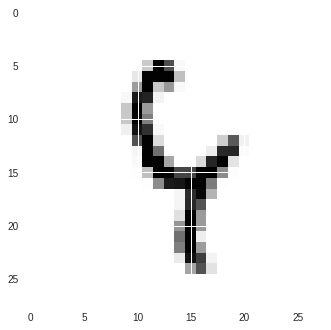

label: [9]
Miss prediction: [7]


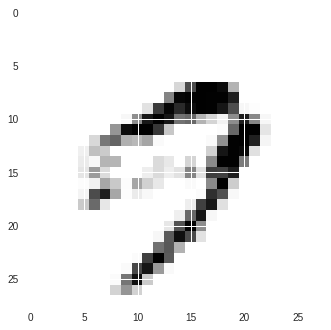

label: [4]
Miss prediction: [9]


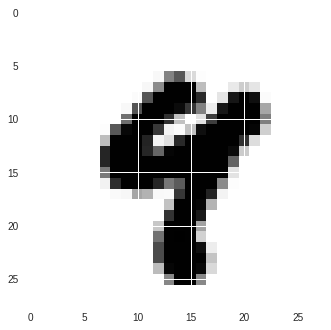

label: [7]
Miss prediction: [1]


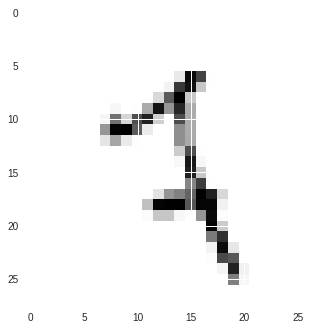

label: [0]
Miss prediction: [6]


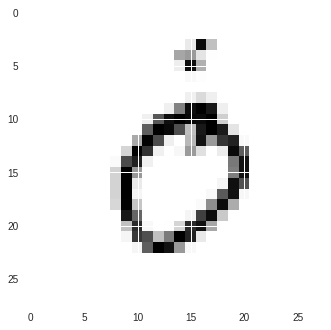

label: [5]
Miss prediction: [3]


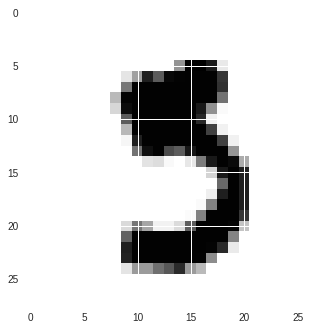

label: [4]
Miss prediction: [9]


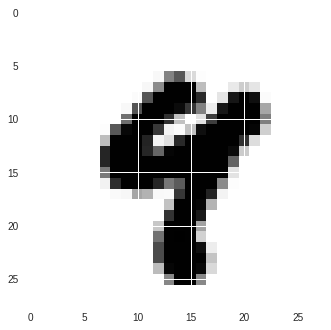

label: [4]
Miss prediction: [9]


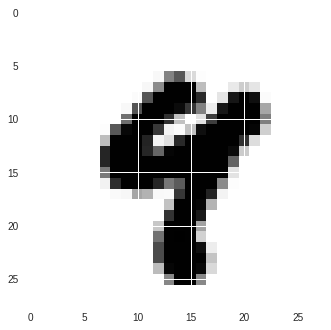

In [77]:
import random
import matplotlib.pyplot as plt



#test_size = len(mnist.test.labels)
for i in range(1000):
  r = random.randint(0, mnist.test.num_examples -1)
  predictions = np.zeros([1,10])
  for m_idx, m in enumerate(models):
    #print(m_idx, "Accuracy", m.get_accuracy(
      #mnist.test.images, mnist.test.labels))
    p = m.predict(mnist.test.images[r:r+1]) #nx10
    #print(predictions) #nx10
    #print(p) 
    predictions += p
  
  pred = sess.run(tf.argmax(predictions, 1))
  label = sess.run(tf.argmax(mnist.test.labels[r:r+1], 1))
  if (pred != label):
    print("label:",label)
    print("Miss prediction:", pred)
    plt.imshow(mnist.test.images[r:r+1].reshape([28,28]), cmap="Greys", interpolation="nearest")
    plt.show()
  
